In [1]:
""" Submission for Kaggle Titanic competition (https://www.kaggle.com/c/titanic). Given a training set
containing information about titanic passenger age, sex, cabin, etc. we predict the pessengers probability of 
survival.  Main methods employed are feature engineering and XGBoost.
"""

' Submission for Kaggle Titanic competition (https://www.kaggle.com/c/titanic). Given a training set\ncontaining information about titanic passenger age, sex, cabin, etc. we predict the pessengers probability of \nsurvival.  Main methods employed are feature engineering and XGBoost.\n'

In [2]:
# import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

## Train Model on the Training Set

### Cleaning & Feature Engineering

In [3]:
def engineer_class(passengers):
    # in Cabin column, remove the numbers and only keep cabin type, e.g. B, C, ...
    # if NaN, replace with "unknown"
    counter = 0
    for cabin in passengers['Cabin']:
        try:
            if math.isnan(float(cabin)):
                passengers['Cabin'].values[counter] = 'unknown'
        except:
            passengers['Cabin'].values[counter] = cabin[0]
        counter += 1
    # cabin type 'T' only exists one time and most closely resembles the behaviour of
    # a cabin type 'A' passenger, therefore replace it
    idx = passengers[passengers['Cabin'] == 'T'].index
    passengers.loc[idx, 'Cabin'] = 'A'

    return passengers

def engineer_age(passengers):
    ## fix age NaNs
    # instead of replacing the age NaNs with a total mean, logically categorize the data and 
    # replace the age with the mean of that category, e.g. class1 males, class1 females, etc.
    passengers['Age'] = passengers.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

    return passengers

def engineer_ticket(passengers):
    # families who boarded together received the same ticker number. since there is a correlation between
    # family size and survival rate, we group the tickets by their frequency
    passengers['Ticket_frequency'] = passengers.groupby('Ticket')['Ticket'].transform('count')
    passengers.drop('Ticket', axis=1, inplace=True)

    return passengers

In [4]:
# load data and apply engineering functions
passengers = pd.read_csv('./data/train.csv', index_col=0)
# process columns Ticket, Age, Class
passengers = engineer_class(passengers)
passengers = engineer_age(passengers)
passengers = engineer_ticket(passengers)
passengers.shape 

(891, 11)

In [5]:
# process Embarked column
print(passengers[passengers['Embarked'].isnull()])
# fill the 2 NaNs with the proper values based on a google search of the passenger names
passengers['Embarked'].fillna('S', inplace=True)

             Survived  Pclass                                       Name  \
PassengerId                                                                
62                  1       1                        Icard, Miss. Amelie   
830                 1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

                Sex   Age  SibSp  Parch  Fare Cabin Embarked  Ticket_frequency  
PassengerId                                                                     
62           female  38.0      0      0  80.0     B      NaN                 2  
830          female  62.0      0      0  80.0     B      NaN                 2  


In [6]:
# create new ordinal feature family_size from Parch (parents+children) and Sibsp (siblings+spouses)
passengers['Family_Size'] = passengers['SibSp'] + passengers['Parch'] + 1
del passengers['SibSp']
del passengers['Parch']

In [7]:
# drop name column (TODO: extract features from the titles, e.g. Mr., Mrs., ...)
del passengers['Name']

In [8]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    int64  
 1   Pclass            891 non-null    int64  
 2   Sex               891 non-null    object 
 3   Age               891 non-null    float64
 4   Fare              891 non-null    float64
 5   Cabin             891 non-null    object 
 6   Embarked          891 non-null    object 
 7   Ticket_frequency  891 non-null    int64  
 8   Family_Size       891 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 101.9+ KB


In [9]:
passengers.sample(5)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Ticket_frequency,Family_Size
PassengerId,,,,,,,,,
436,1,1,female,14.00,120.0000,B,S,4,4
832,1,2,male,0.83,18.7500,unknown,S,3,3
215,0,3,male,25.00,7.7500,unknown,Q,1,2
56,1,1,male,40.00,35.5000,C,S,1,1
31,0,1,male,40.00,27.7208,unknown,C,1,1


In [10]:
# confirm that data is clean: count NaNs for each column
for column in passengers.columns:
    print('Nr. of NaN in column ' + column + ' ' + str(passengers[column].isna().sum()))

Nr. of NaN in column Survived 0
Nr. of NaN in column Pclass 0
Nr. of NaN in column Sex 0
Nr. of NaN in column Age 0
Nr. of NaN in column Fare 0
Nr. of NaN in column Cabin 0
Nr. of NaN in column Embarked 0
Nr. of NaN in column Ticket_frequency 0
Nr. of NaN in column Family_Size 0


### Encoding

In [11]:
# split features and target values
X = passengers.drop('Survived', axis=1)
y = passengers['Survived']

In [12]:
# one-hot encode Sex
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), ['Sex']), remainder='passthrough', verbose_feature_names_out=False)
X = pd.DataFrame(transformer.fit_transform(X), columns=transformer.get_feature_names_out()) # put transformed feature back in X

In [13]:
# one-hot encode Embarked
transformer = make_column_transformer((OneHotEncoder(), ['Embarked']), remainder='passthrough', verbose_feature_names_out=False)
X = pd.DataFrame(transformer.fit_transform(X), columns=transformer.get_feature_names_out()) # put transformed feature back in X

In [14]:
# one-hot encode Cabin
transformer = make_column_transformer((OneHotEncoder(), ['Cabin']), remainder='passthrough', verbose_feature_names_out=False)
X = pd.DataFrame(transformer.fit_transform(X), columns=transformer.get_feature_names_out()) # put transformed feature back in X

X_encoded = X.astype(int)

# Model on Training Data

In [15]:
# ## Train the Model on the whole set
# # Random forest with optimized params from GridSearch
#classifier = RandomForestClassifier(n_estimators=45, max_features=11, criterion='entropy', random_state=0)
#classifier.fit(X_encoded, y)

In [16]:
## XGboost - with grid search
saved_params = {'colsample_bytree': 0.71, 'gamma': 0.17, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 54, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.72} # if empty, run a grid search for optimized parameters, kaggle score: 0.78

if len(saved_params) == 0:

    classifier = XGBClassifier(n_estimators=50, max_depth=5, max_leaves=0, min_child_weight = 1, learning_rate=0.2,
                                gamma=0.1,
                                verbosity=1,
                                colsample_bytree = 0.8,
                                scale_pos_weight = 1,
                                booster='gbtree', # gblinear, gbtree, dart
                                n_jobs=4,
    )

    # GridSearch
    parameters = [{'max_depth': range(1,15,1),
                    #'min_child_weight': range(2,6,1),
                    #'gamma': np.arange(0.1,0.2,0.02),
                    # 'subsample': np.arange(0.7,0.75,0.01),
                    #'colsample_bytree': np.arange(0.65,0.75,0.025),
                    #'reg_alpha': np.arange(0,1e-5,5e-6),
                    #'reg_lambda': np.arange(0.1,1.1,0.2),
                    'n_estimators': range(50,70,1),
                    #'learning_rate': np.arange(0.05,0.25,0.05)
    }]
    grid_search = GridSearchCV(estimator = classifier,
                                param_grid = parameters,
                                scoring = 'accuracy',
                                cv = 5,
                                n_jobs=2,
                                verbose=2,
    )
    grid_search.fit(X_encoded, y)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

    saved_params = best_parameters

In [17]:
## XGboost with params
classifier = XGBClassifier(**saved_params)
classifier.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.71,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.17, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=54, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1.0, ...)

In [18]:
# check cross-validation
results = cross_val_score(classifier, X_encoded, y, cv=5, verbose=4)
results.mean()

[CV] END ................................ score: (test=0.804) total time=   0.0s
[CV] END ................................ score: (test=0.820) total time=   0.0s
[CV] END ................................ score: (test=0.865) total time=   0.0s
[CV] END ................................ score: (test=0.820) total time=   0.0s
[CV] END ................................ score: (test=0.854) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


0.832803967108154

<AxesSubplot:xlabel='Feature', ylabel='Importance'>

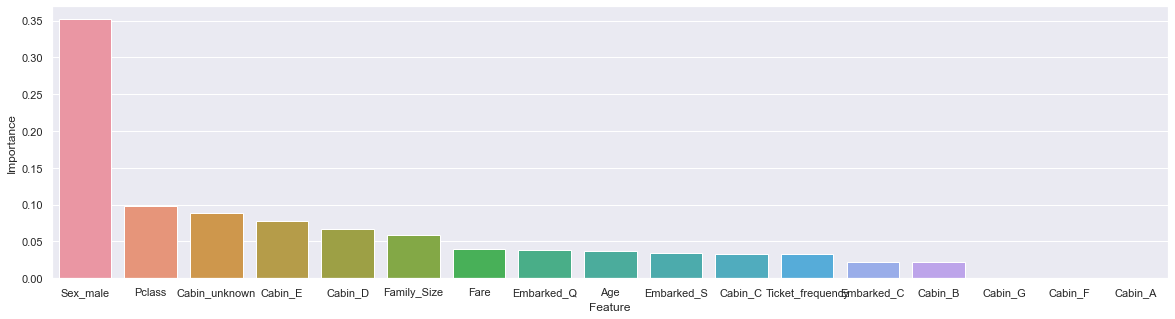

In [19]:
# draw histogram of importances of each feature
importances = pd.DataFrame(zip(classifier.feature_importances_,classifier.feature_names_in_), columns=['Importance', 'Feature'])
importances.sort_values(by='Importance', inplace=True, ascending=False)
plt.figure(figsize=(20, 5))
sns.barplot(x='Feature', y='Importance', data=importances)

## Prepare the Test Data

In [20]:
passengers_test = pd.read_csv('./data/test.csv', index_col=0)
# process columns Ticket, Age, Class
passengers_test = engineer_class(passengers_test)
passengers_test = engineer_age(passengers_test)
passengers_test = engineer_ticket(passengers_test)

del passengers_test['Name']
passengers_test.shape 

(418, 9)

In [21]:
# counts NaNs for each column
for column in passengers_test.columns:
    print('Nr. of NaN in column ' + column + ' ' + str(passengers_test[column].isna().sum()))
passengers_test[passengers_test['Fare'].isnull()]    

Nr. of NaN in column Pclass 0
Nr. of NaN in column Sex 0
Nr. of NaN in column Age 0
Nr. of NaN in column SibSp 0
Nr. of NaN in column Parch 0
Nr. of NaN in column Fare 1
Nr. of NaN in column Cabin 0
Nr. of NaN in column Embarked 0
Nr. of NaN in column Ticket_frequency 0


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_frequency
PassengerId,,,,,,,,,
1044,3,male,60.5,0,0,NaN,unknown,S,1


In [22]:
# fill the 1 NaN in Fare 
class3_male_fare_mean = passengers_test[(passengers_test['Pclass']==3) & (passengers_test['Sex']=='male')]['Fare'].mean() # mean fare of Class 3 males
passengers_test.loc[(passengers_test['Pclass']==3) & (passengers_test['Sex']=='male') & (passengers_test['Fare'].isnull()), 'Fare'] = class3_male_fare_mean

In [23]:
# create new ordinal feature family_size from Parch (parents+children) and Sibsp (siblings+spouses)
passengers_test['Family_Size'] = passengers_test['SibSp'] + passengers_test['Parch'] + 1
del passengers_test['SibSp']
del passengers_test['Parch']

In [24]:
# encode categorical data
# one-hot encode Sex
X = passengers_test
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), ['Sex']), remainder='passthrough', verbose_feature_names_out=False)
X = pd.DataFrame(transformer.fit_transform(X), columns=transformer.get_feature_names_out()) # put transformed feature back in X
# one-hot encode Embarked
transformer = make_column_transformer((OneHotEncoder(), ['Embarked']), remainder='passthrough', verbose_feature_names_out=False)
X = pd.DataFrame(transformer.fit_transform(X), columns=transformer.get_feature_names_out()) # put transformed feature back in X
# one-hot encode Cabin
transformer = make_column_transformer((OneHotEncoder(), ['Cabin']), remainder='passthrough', verbose_feature_names_out=False)
X = pd.DataFrame(transformer.fit_transform(X), columns=transformer.get_feature_names_out()) # put transformed feature back in X

id_column = passengers_test.index
X_test_encoded = X.astype(int)
X_test_encoded.shape

(418, 17)

In [25]:
X_test_encoded

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_unknown,Embarked_C,Embarked_Q,Embarked_S,Sex_male,Pclass,Age,Fare,Ticket_frequency,Family_Size
0,0,0,0,0,0,0,0,1,0,1,0,1,3,34,7,1,1
1,0,0,0,0,0,0,0,1,0,0,1,0,3,47,7,1,2
2,0,0,0,0,0,0,0,1,0,1,0,1,2,62,9,1,1
3,0,0,0,0,0,0,0,1,0,0,1,1,3,27,8,1,1
4,0,0,0,0,0,0,0,1,0,0,1,0,3,22,12,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,0,0,0,0,0,1,0,0,1,1,3,24,8,1,1
414,0,0,1,0,0,0,0,0,1,0,0,0,1,39,108,1,1
415,0,0,0,0,0,0,0,1,0,0,1,1,3,38,7,1,1
416,0,0,0,0,0,0,0,1,0,0,1,1,3,24,8,1,1


In [26]:
# make predictions based on Model
y_pred_test = classifier.predict(X_test_encoded)
y_pred_test.shape

(418,)

In [27]:
# write titanic kaggle .csv submission
y_pred_column = pd.DataFrame(y_pred_test, id_column, columns=['Survived'])
y_pred_column.to_csv('./output/solution.csv')